## SEE_PY

- Zeus Elderfield
- Earl Rondina

## Instructions

Assignment 2 For Clustering: Sessa Empirical Estimator
1. Read the Journals about the Sessa Empirical Estimator.
2. Convert the R codes into Python Codes (use jupyter notebook).
3. Using Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or a real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/), perform the Sessa Empircal Estimator and generate some insights.
4. The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.
5. Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.
6. Deadline is this Sunday, Feb 23, 2025 at 11:59 pm
7. Do this with your thesis partner.
8. You can use any A.I. assistant.

## Import Libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

### Import dataset

In [13]:
# Simulated data is based on: https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full
simulated_df = pd.read_csv('../data/simulated_data.csv')

simulated_df.tail()

,individual,group,refill_date,refill_duration
10662,1000,4,540,30.0
10663,1000,4,630,90.0
10664,1000,4,660,30.0
10665,1000,4,690,30.0
10666,1000,4,720,30.0


In [14]:
simulated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10667 entries, 0 to 10666
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   individual       10667 non-null  int64  
 1   group            10667 non-null  int64  
 2   refill_date      10667 non-null  int64  
 3   refill_duration  9667 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 333.5 KB


### Define Function/s

#### I. Sessa Empirical Estimator using K-means clustering

In [15]:
def See_KMeans(data):
    """
    Sessa Empirical Estimator using K-means clustering.

    This function expects a DataFrame (e.g. from simulate_refill_history) with at least:
      - 'individual': patient ID
      - 'refill_date': the refill day (numeric, e.g. 0, 30, 90, ...)
      - (optionally) 'group': the simulated adherence group

    Then it:
      1. Sorts the data by patient and refill date.
      2. Computes the lag refill date (prev_refill_date) for each patient.
      3. Keeps only patients with at least one refill (i.e. with a non-null prev_refill_date)
         and randomly samples one event per patient.
      4. Computes the event interval (difference in days).
      5. Computes the empirical CDF (ECDF) of these intervals and retains the lower 80%.
      6. Estimates a density on the log-transformed intervals and performs silhouette
         analysis to determine the optimal number of clusters.
      7. Runs k-means clustering on the ECDF x-values and, for each cluster, computes
         summary thresholds (minimum, maximum, median) after back-transforming.
      8. Cross-joins these thresholds with the patient-level data and assigns a cluster
         if the event interval falls within a cluster’s [Minimum, Maximum] range.
      9. Uses the most frequent cluster’s median as a fallback, and adds a “test” column
         (difference between event interval and median).

    Returns a DataFrame with additional columns: 'event_interval', 'Median', 'Cluster', and 'test'.
    """
    # Rename columns for consistency.
    df = data.copy()

    # Sort by patient and refill date; compute the previous refill date for each patient.
    df_sorted = df.sort_values(by=['individual', 'refill_date']).copy()
    df_sorted['prev_refill_date'] = df_sorted.groupby('individual')['refill_date'].shift(1)

    # Keep only rows with a previous event.
    df_sample = df_sorted.dropna(subset=['prev_refill_date']).copy()

    # For each patient, randomly sample one refill event.
    df_sample = (df_sample.groupby('individual', group_keys=False)
                 .apply(lambda x: x.sample(n=1, random_state=1234))
                 .reset_index(drop=True))

    # Compute the event interval. For simulated data, 'refill_date' is numeric.
    df_sample['event_interval'] = df_sample['refill_date'] - df_sample['prev_refill_date']

    # --- ECDF Calculation ---
    intervals = np.sort(df_sample['event_interval'].values)
    n = len(intervals)
    y_ecdf = np.arange(1, n + 1) / n
    df_ecdf = pd.DataFrame({'x': intervals, 'y': y_ecdf})

    # Retain the lower 80% of the ECDF.
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8].copy()
    ni = df_ecdf_80['x'].max()

    # (Optional) Plot the ECDFs.
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(df_ecdf_80['x'], df_ecdf_80['y'])
    plt.title("80% ECDF")
    plt.xlabel("Event Interval")
    plt.ylabel("ECDF")
    plt.subplot(1, 2, 2)
    plt.scatter(df_ecdf['x'], df_ecdf['y'])
    plt.title("100% ECDF")
    plt.xlabel("Event Interval")
    plt.ylabel("ECDF")
    plt.tight_layout()
    plt.show()

    # (Optional) Plot patient frequency.
    freq = df_sample['individual'].value_counts()
    plt.figure(figsize=(6, 4))
    freq.plot(kind='bar', title="Frequency of individual")
    plt.xlabel("individual")
    plt.ylabel("Count")
    plt.show()

    # Select rows with event_interval <= ni.
    df_for_density = df_sample[df_sample['event_interval'] <= ni].copy()

    # Density estimation on the log-transformed event intervals.
    log_intervals = np.log(df_for_density['event_interval'])
    grid = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    kde = gaussian_kde(log_intervals)
    density_values = kde(grid)
    plt.figure(figsize=(6, 4))
    plt.plot(grid, density_values)
    plt.title("Density of log(Event Interval)")
    plt.xlabel("log(Event Interval)")
    plt.ylabel("Density")
    plt.show()

    # Create a DataFrame from the density estimation and scale it.
    density_df = pd.DataFrame({'x': grid, 'y': density_values})
    scaler = StandardScaler()
    density_scaled = scaler.fit_transform(density_df)

    # Silhouette analysis to choose the optimal number of clusters.
    best_k = 2
    best_score = -1
    max_k = min(10, len(density_scaled))
    for k in range(2, max_k + 1):
        km_temp = KMeans(n_clusters=k, random_state=1234, n_init=10)
        labels_temp = km_temp.fit_predict(density_scaled)
        score = silhouette_score(density_scaled, labels_temp)
        if score > best_score:
            best_score = score
            best_k = k
    optimal_k = best_k
    print("Optimal number of clusters:", optimal_k)

    # K-means clustering on the full ECDF x-values.
    x_for_cluster = df_ecdf['x'].values.reshape(-1, 1)
    km = KMeans(n_clusters=optimal_k, random_state=1234)
    cluster_labels = km.fit_predict(x_for_cluster)
    df_ecdf['cluster'] = cluster_labels
    df_ecdf['log_x'] = np.log(df_ecdf['x'])

    # For each cluster, compute the minimum, maximum, and median of log_x; then back-transform.
    summary = (df_ecdf.groupby('cluster')['log_x']
               .agg(['min', 'max', 'median'])
               .reset_index())
    summary['min'] = summary['min'].replace(-np.inf, 0)
    summary['Minimum'] = np.exp(summary['min'])
    summary['Maximum'] = np.exp(summary['max'])
    summary['Median'] = np.exp(summary['median'])
    summary = summary[summary['Median'] > 0]
    summary = summary[['cluster', 'Minimum', 'Maximum', 'Median']].rename(columns={'cluster': 'Cluster_sum'})

    # Cross join: assign every row in df_sample the summary thresholds.
    df_sample['key'] = 1
    summary['key'] = 1
    cross = pd.merge(df_sample, summary, on='key').drop('key', axis=1)

    # Assign a Final_cluster value if the event_interval falls within the thresholds.
    cross['Final_cluster'] = np.where(
        (cross['event_interval'] >= cross['Minimum']) & (cross['event_interval'] <= cross['Maximum']),
        cross['Cluster_sum'], np.nan
    )
    results = cross.dropna(subset=['Final_cluster']).copy()
    results = results[['individual', 'Median', 'Cluster_sum']].rename(columns={'Cluster_sum': 'Cluster'})

    # Use the most frequent cluster's median as a fallback.
    if not results.empty:
        top_cluster = results['Cluster'].value_counts().idxmax()
        fallback_median = results.loc[results['Cluster'] == top_cluster, 'Median'].iloc[0]
    else:
        fallback_median = np.nan

    # Merge the cluster results back into the sampled data.
    df_sample = pd.merge(df_sample, results, on='individual', how='left', suffixes=('', '_res'))
    # The merge will bring in the "Median" column from results (no suffix needed)
    df_sample['Median'] = df_sample['Median'].fillna(fallback_median)
    df_sample['Cluster'] = df_sample['Cluster'].fillna(0)
    df_sample['test'] = np.round(df_sample['event_interval'] - df_sample['Median'], 1)

    # Select and return relevant columns.
    df_final = df_sample[['individual', 'refill_date', 'prev_refill_date', 'event_interval', 'Median', 'Cluster', 'test']].copy()
    return df_final

#### II. Sessa Empirical Estimator using DBSCAN

In [16]:
def See_DBSCAN(data, optimize=True, candidate_eps=None, candidate_min_samples=None, default_eps=10, default_min_samples=2):
    """
    Sessa Empirical Estimator using DBSCAN clustering with internal parameter optimization.

    This function expects a DataFrame (e.g. from simulate_refill_history) with at least:
      - 'individual': patient ID
      - 'refill_date': the refill day (numeric, e.g. 0, 30, 90, ...)
      - (optionally) 'group': the simulated adherence group

    Then it:
      1. Sorts the data by patient and refill date.
      2. Computes the lag refill date (prev_refill_date) for each patient.
      3. Keeps only patients with at least one refill (i.e. with a non-null prev_refill_date)
         and randomly samples one event per patient.
      4. Computes the event interval (difference in days).
      5. Computes the empirical CDF (ECDF) of these intervals and retains the lower 80%.
      6. Estimates a density on the log-transformed intervals.
      7. (Optionally) Performs a grid search over candidate DBSCAN parameters (eps and min_samples)
         using the silhouette score on the 1D ECDF x-values (excluding noise).
      8. Runs DBSCAN with the optimal (or default) parameters on the ECDF x-values.
      9. For each resulting cluster (ignoring noise), computes summary thresholds (min, max, median)
         on the log-transformed x-values (back-transformed to the original scale).
     10. Cross-joins these thresholds with the patient-level data and assigns a cluster if the
         event interval falls within a cluster’s [Minimum, Maximum] range.
     11. Uses the most frequent cluster’s median as a fallback and adds a “test” column (the difference
         between the event interval and the median).

    Returns:
      A DataFrame with additional columns: 'event_interval', 'Median', 'Cluster', and 'test'.
    """
    # Work on a copy.
    df = data.copy()

    # Sort by patient and refill date; compute previous refill date.
    df_sorted = df.sort_values(by=['individual', 'refill_date']).copy()
    df_sorted['prev_refill_date'] = df_sorted.groupby('individual')['refill_date'].shift(1)

    # Keep only rows with a previous event.
    df_sample = df_sorted.dropna(subset=['prev_refill_date']).copy()

    # For each patient, randomly sample one refill event.
    df_sample = (df_sample.groupby('individual', group_keys=False)
                 .apply(lambda x: x.sample(n=1, random_state=1234))
                 .reset_index(drop=True))

    # Compute the event interval (numeric subtraction for simulated data).
    df_sample['event_interval'] = df_sample['refill_date'] - df_sample['prev_refill_date']

    # --- ECDF Calculation ---
    intervals = np.sort(df_sample['event_interval'].values)
    n = len(intervals)
    y_ecdf = np.arange(1, n + 1) / n
    df_ecdf = pd.DataFrame({'x': intervals, 'y': y_ecdf})

    # Retain the lower 80% of the ECDF.
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8].copy()
    ni = df_ecdf_80['x'].max()

    # (Optional) Plot the ECDFs.
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(df_ecdf_80['x'], df_ecdf_80['y'])
    plt.title("80% ECDF")
    plt.xlabel("Event Interval")
    plt.ylabel("ECDF")
    plt.subplot(1, 2, 2)
    plt.scatter(df_ecdf['x'], df_ecdf['y'])
    plt.title("100% ECDF")
    plt.xlabel("Event Interval")
    plt.ylabel("ECDF")
    plt.tight_layout()
    plt.show()

    # (Optional) Plot patient frequency.
    freq = df_sample['individual'].value_counts()
    plt.figure(figsize=(6, 4))
    freq.plot(kind='bar', title="Frequency of individual")
    plt.xlabel("individual")
    plt.ylabel("Count")
    plt.show()

    # Select rows with event_interval <= ni.
    df_for_density = df_sample[df_sample['event_interval'] <= ni].copy()

    # Density estimation on the log-transformed event intervals.
    log_intervals = np.log(df_for_density['event_interval'])
    grid = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    kde = gaussian_kde(log_intervals)
    density_values = kde(grid)
    plt.figure(figsize=(6, 4))
    plt.plot(grid, density_values)
    plt.title("Density of log(Event Interval)")
    plt.xlabel("log(Event Interval)")
    plt.ylabel("Density")
    plt.show()

    # Create a DataFrame from the density estimation and scale it.
    density_df = pd.DataFrame({'x': grid, 'y': density_values})
    scaler = StandardScaler()
    density_scaled = scaler.fit_transform(density_df)

    # ---- DBSCAN Parameter Optimization ----
    # Use the ECDF x-values as our clustering target.
    x_for_cluster = df_ecdf['x'].values.reshape(-1, 1)

    if optimize:
        # Define candidate values if not provided.
        if candidate_eps is None:
            candidate_eps = np.linspace(5, 20, num=16)  # e.g., 5, 6, ..., 20
        if candidate_min_samples is None:
            candidate_min_samples = range(2, 7)  # 2 to 6
        best_score = -1
        best_params = None
        for eps_val in candidate_eps:
            for min_samples_val in candidate_min_samples:
                db_candidate = DBSCAN(eps=eps_val, min_samples=min_samples_val)
                labels_candidate = db_candidate.fit_predict(x_for_cluster)
                # Only consider points not labeled as noise (-1)
                mask = labels_candidate != -1
                # Require at least two clusters.
                if len(np.unique(labels_candidate[mask])) < 2:
                    continue
                try:
                    score = silhouette_score(x_for_cluster[mask], labels_candidate[mask])
                except Exception:
                    continue
                if score > best_score:
                    best_score = score
                    best_params = (eps_val, min_samples_val)
        if best_params is not None:
            optimal_eps, optimal_min_samples = best_params
            print("Optimal DBSCAN parameters found: eps =", optimal_eps,
                  "min_samples =", optimal_min_samples, "with silhouette score =", best_score)
        else:
            optimal_eps = default_eps
            optimal_min_samples = default_min_samples
            print("No optimal DBSCAN parameters found; using defaults: eps =", default_eps,
                  "min_samples =", default_min_samples)
    else:
        optimal_eps = default_eps
        optimal_min_samples = default_min_samples
        print("Optimization disabled; using: eps =", default_eps, "min_samples =", default_min_samples)

    # ---- Run DBSCAN with Optimal Parameters ----
    db = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples - 1)
    labels_db = db.fit_predict(x_for_cluster)
    df_ecdf['cluster'] = labels_db
    df_ecdf['log_x'] = np.log(df_ecdf['x'])

    # Remove noise (label -1) for threshold calculation.
    # df_ecdf_valid = df_ecdf[df_ecdf['cluster'] != -1].copy()

    # For each cluster, compute summary statistics on log_x; then back-transform.
    summary = (df_ecdf.groupby('cluster')['log_x']
               .agg(['min', 'max', 'median'])
               .reset_index())
    summary['min'] = summary['min'].replace(-np.inf, 0)
    summary['Minimum'] = np.exp(summary['min'])
    summary['Maximum'] = np.exp(summary['max'])
    summary['Median'] = np.exp(summary['median'])
    summary = summary[summary['Median'] > 0]
    summary = summary[['cluster', 'Minimum', 'Maximum', 'Median']].rename(columns={'cluster': 'Cluster_sum'})

    # ---- Cross Join Thresholds to Patient Data ----
    df_sample['key'] = 1
    summary['key'] = 1
    cross = pd.merge(df_sample, summary, on='key').drop('key', axis=1)

    # Assign Final_cluster if the event_interval falls within the thresholds.
    cross['Final_cluster'] = np.where(
        (cross['event_interval'] >= cross['Minimum']) & (cross['event_interval'] <= cross['Maximum']),
        cross['Cluster_sum'], np.nan
    )
    results = cross.dropna(subset=['Final_cluster']).copy()
    results = results[['individual', 'Median', 'Cluster_sum']].rename(columns={'Cluster_sum': 'Cluster'})

    # Use the most frequent cluster's median as a fallback.
    if not results.empty:
        top_cluster = results['Cluster'].value_counts().idxmax()
        fallback_median = results.loc[results['Cluster'] == top_cluster, 'Median'].iloc[0]
    else:
        fallback_median = np.nan

    # Merge the cluster results back into the sampled data.
    df_sample = pd.merge(df_sample, results, on='individual', how='left')
    df_sample['Median'] = df_sample['Median'].fillna(fallback_median)
    df_sample['Cluster'] = df_sample['Cluster'].fillna(0)
    df_sample['test'] = np.round(df_sample['event_interval'] - df_sample['Median'], 1)

    # Select and return relevant columns.
    df_final = df_sample[['individual', 'refill_date', 'prev_refill_date', 'event_interval', 'Median', 'Cluster', 'test']].copy()
    return df_final

#### III. SEE Assumption

In [17]:
def see_assumption(data):
    """
    Given a DataFrame (df_final) from the Sessa Empirical Estimator,
    this function creates a boxplot of the refill event intervals (in days)
    grouped by the assigned Cluster. It also draws a horizontal dashed red line
    at the overall median event interval.

    Parameters:
      data (DataFrame): The output from the Sessa estimator containing at least
                        'individual', 'event_interval', and 'Cluster'.

    Returns:
      Matplotlib Figure object.
    """
    # Create a copy so as not to modify the original data.
    df = data.copy()

    # Ensure the Cluster column is treated as categorical.
    df['Cluster'] = df['Cluster'].astype('category')

    # Compute the overall median event interval.
    overall_median = df['event_interval'].median()

    # Create the boxplot.
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(x='Cluster', y='event_interval', data=df)
    ax.set_title("Boxplot of Refill Event Interval by Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Event Interval (days)")

    # Add a horizontal dashed line at the overall median.
    plt.axhline(y=overall_median, color='red', linestyle='dashed',
                label=f'Overall median = {overall_median:.1f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return plt.gcf()

### Simulate

#### I. Sessa Empirical Estimator using K Means

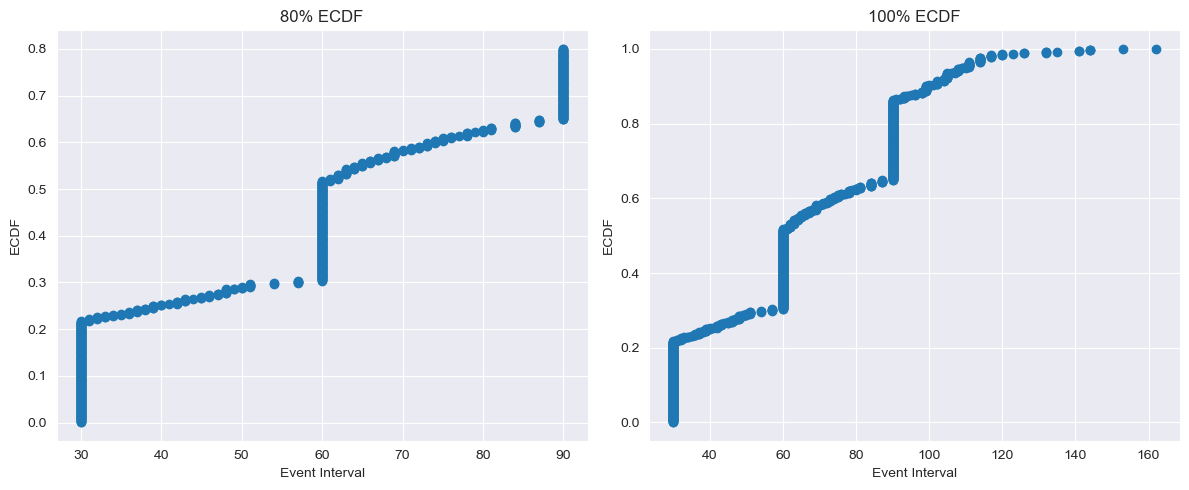

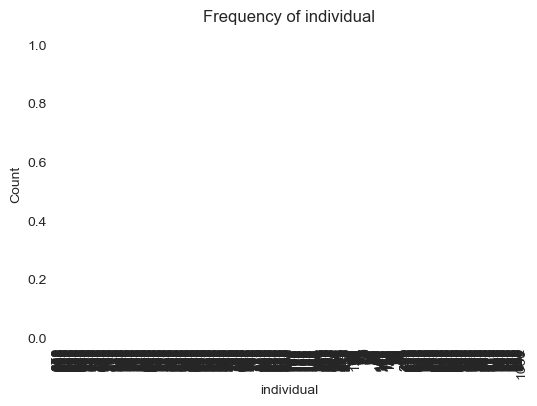

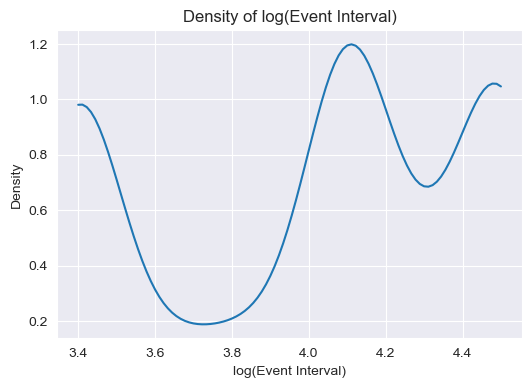

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Optimal number of clusters: 3


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,individual,refill_date,prev_refill_date,event_interval,Median,Cluster,test
0,1,704,600.0,104.0,90.0,1.0,14.0
1,2,510,480.0,30.0,90.0,0.0,-60.0
2,3,690,630.0,60.0,60.0,2.0,0.0
3,4,540,448.0,92.0,90.0,1.0,2.0
4,5,660,600.0,60.0,60.0,2.0,0.0


In [18]:
see_kmc_df = See_KMeans(simulated_df)

see_kmc_df.head()

#### II. Sessa Empirical Estimator using DBSCAN

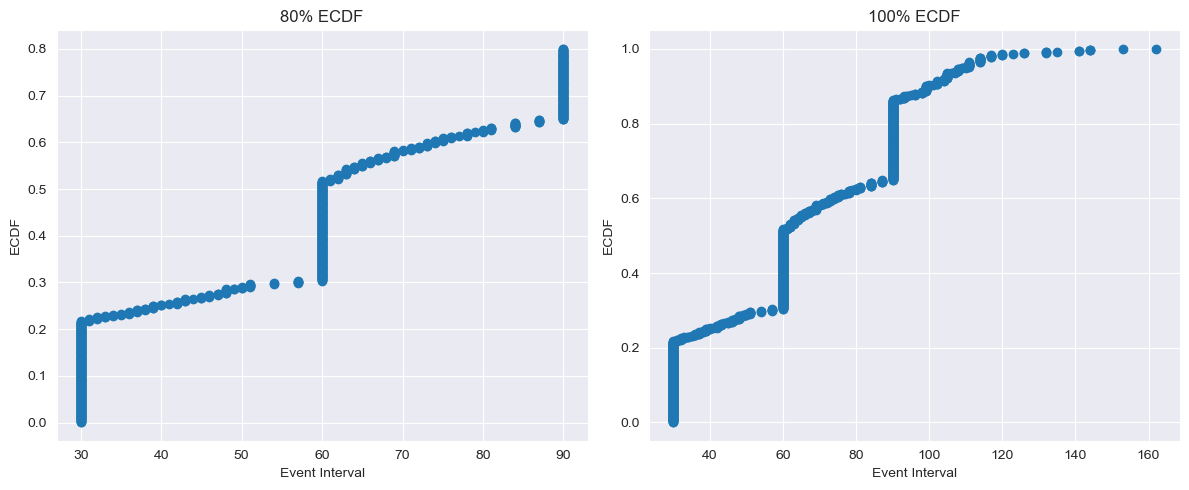

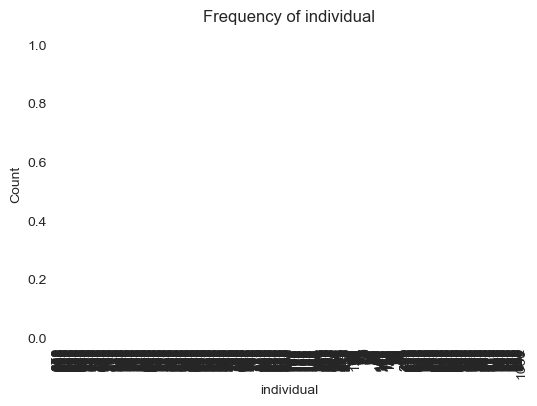

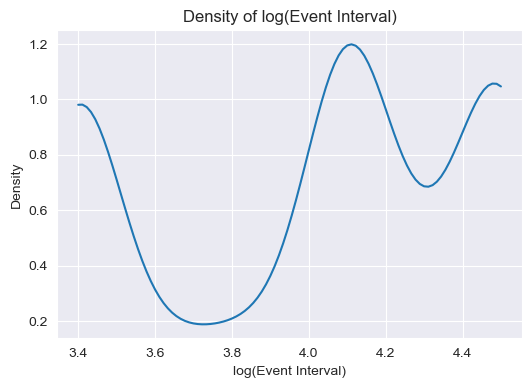

Optimal DBSCAN parameters found: eps = 5.0 min_samples = 5 with silhouette score = 0.5533068642773133


,individual,refill_date,prev_refill_date,event_interval,Median,Cluster,test
0,1,704,600.0,104.0,60.0,0.0,44.0
1,2,510,480.0,30.0,60.0,0.0,-30.0
2,3,690,630.0,60.0,60.0,0.0,0.0
3,4,540,448.0,92.0,60.0,0.0,32.0
4,5,660,600.0,60.0,60.0,0.0,0.0


In [19]:
see_dbscan_df = See_DBSCAN(simulated_df, optimize=True)

see_dbscan_df.head()

#### III. Assumption for Sessa Empirical Estimator using K Means

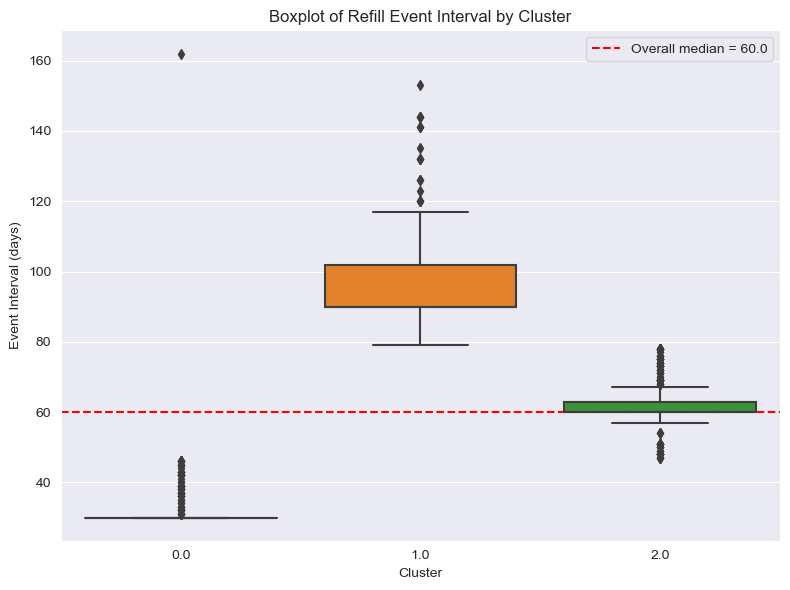

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [22]:
see_assumption(see_kmc_df)


#### IV. Assumption for Sessa Empirical Estimator using DBSCAN

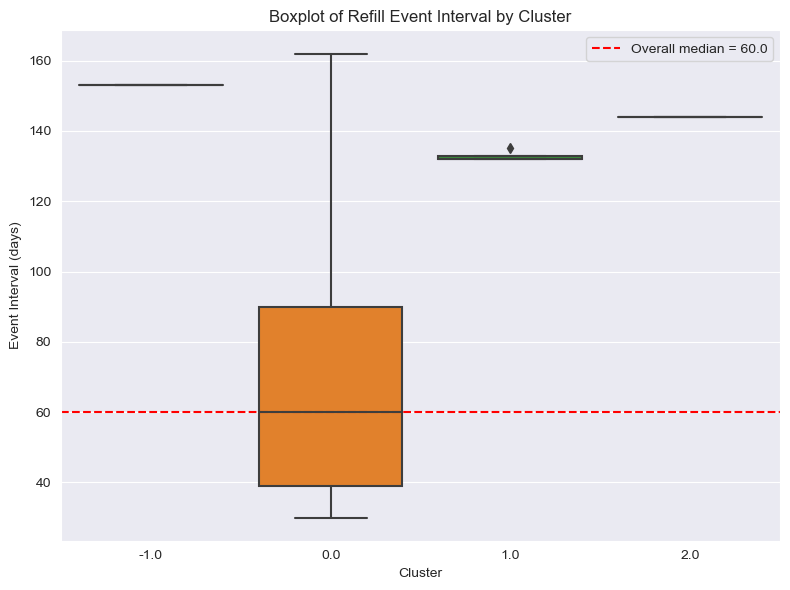

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [21]:
see_assumption(see_dbscan_df)

### Insights

#### I. K Means Clustering Insights
- Three Clusters (0, 1, 2): The boxplot using K-Means displays three distinct clusters.
- Cluster 0: This cluster has a wide range of event intervals, with a significant number of outliers at the lower end (around 30 days). This suggests a group of patients or entities that have frequent refills.
- Cluster 1: The median event interval is much higher (~90-100 days), with a broad interquartile range (IQR) and several extreme outliers. This indicates a group with much longer refill intervals, suggesting a pattern of delayed or less frequent refills.
- Cluster 2: The median event interval is close to 60 days, aligning with the overall median. The cluster appears tightly packed, with less variability and fewer outliers, which suggests a stable refill pattern.
- Observations:
    - The clustering seems to capture three distinct refill behaviors: frequent refills (Cluster 0), long refill intervals (Cluster 1), and standard refill behavior (Cluster 2).
    - K-Means assumes clusters are spherical and of similar sizes, which may not always be the case in real-world data.

> **DISADVANTAGE**: KMeans assumes clusters are spherical and of similar sizes, which can lead to poor performance when dealing with irregularly shaped or varying-density clusters.
For example, if clusters in the data have different densities or overlapping boundaries, K-Means may incorrectly assign points or fail to separate meaningful groups. This is especially problematic when dealing with real-world datasets where clusters may not be well-defined.

#### II. DBSCAN Clustering Insights
- Noise (-1 Cluster): DBSCAN identifies an additional "noise" cluster (-1), which consists of outliers that do not fit well into any cluster. These are likely extreme behaviors in refill patterns.
- Cluster 0: This is the largest cluster and has a similar median event interval (~60 days) to the overall median.
- Cluster 1 & 2: These clusters seem to capture patients or entities with much longer refill intervals (~140-160 days).
- Observations:
    - DBSCAN is density-based, meaning it groups points that are closely packed together and marks sparse points as noise. This is useful for identifying outliers in refill patterns.
    - Unlike K-Means, DBSCAN does not force all points into clusters, allowing for a more natural grouping of refill behaviors.
    - The presence of an outlier cluster (-1) suggests that DBSCAN is more effective at separating irregular refill patterns.

> **DISADVANTAGE**: DBSCAN struggles with high-dimensional data because its concept of "density" becomes less meaningful as the number of dimensions increases. For example, in datasets with many features, the distance between points becomes more uniform (a phenomenon known as the curse of dimensionality), making it difficult for DBSCAN to identify dense regions effectively. As a result, it may misclassify clusters or label too many points as noise.

#### III. Comparison Between K Means and DBSCAN

| Criteria                  | K-Means (Sessa + K-Means)   | DBSCAN (Sessa + DBSCAN)             |
|---------------------------|----------------------------|-------------------------------------|
| **Cluster Count**         | 3 (fixed by algorithm)     | 3 + noise (-1) (optimal)            |
| **Handling of Outliers**  | Outliers remain in clusters | Outliers are separated (-1 cluster) |
| **Cluster Shape Assumption** | Spherical, equal-size clusters | No assumption on shape              |
| **Interpretation**        | Predefined cluster structure | Flexible, more natural clustering   |
| **Best For**              | Well-separated, balanced data | Varying density, outlier detection  |


#### IV. Key Takeaways
- K-Means effectively groups refill behaviors into three distinct clusters but assumes similar cluster sizes and shapes, which may not always be the case.
- DBSCAN provides better flexibility in detecting outliers and handling varying densities, making it ideal for datasets where refill behaviors are not well-separated.
- The presence of noise (-1) in DBSCAN suggests that there are significant outliers or irregular refill behaviors that K-Means fails to distinguish.
- If the goal is strictly categorizing refill behavior, K-Means works well. However, if detecting outliers and non-uniform cluster shapes is important, DBSCAN is superior.